Importing Necessary Libraries

In [37]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Creation of Class Matrix

In [25]:
class Matrix:
    # Constructor that loads data from a CSV file and optionally standardizes it

    def __init__(self, filename, standardize=True):
        self.array_2d = self.load_from_csv(filename)  # Load data into a 2D array
        if standardize and self.array_2d is not None:
            self.standardize()  # Standardize the data if needed

    # Load CSV data and convert it into a NumPy array

    def load_from_csv(self, filename):
        try:
            data = pd.read_csv(filename).to_numpy()  # Convert the data into a NumPy array
            return data  # Return the loaded data
        except Exception as e:
            print(f"Error loading file: {e}")  # Print an error message if loading fails
            return None
        
    # Standardize each column of data by adjusting the values so they are more comparable

    def standardize(self):
        for j in range(self.array_2d.shape[1]):  # Go through each column
            column = self.array_2d[:, j]  # Get all the values in that column
            avg = np.mean(column)  # Find the average (mean) of the column
            max_val = np.max(column)  # Get the maximum value
            min_val = np.min(column)  # Get the minimum value
            self.array_2d[:, j] = (column - avg) / (max_val - min_val)  # Standardize the column values

    # Calculate the Euclidean distance from one row to all rows in another matrix

    def get_distance(self, other_matrix, row_index):
        row = self.array_2d[row_index]  # Get the row for which we're calculating distances
        distances = np.sqrt(np.sum((other_matrix.array_2d - row) ** 2, axis=1))  # Calculate distances
        return distances.reshape(-1, 1)  # Return distances as a column

    # Calculate the Euclidean distance but with weights applied to each feature

    def get_weighted_distance(self, other_matrix, weights, row_index):
        row = self.array_2d[row_index]  # Get the specific row to compare
        weighted_diffs = (other_matrix.array_2d - row) * weights.array_2d  # Apply the weights
        distances = np.sqrt(np.sum(weighted_diffs ** 2, axis=1))  # Calculate weighted distances
        return distances.reshape(-1, 1)  # Return as a column of distances



Standalone Functions


In [26]:
# Count how many times each value appears in S (used for counting group sizes)

def get_count_frequency(S):
    unique, counts = np.unique(S, return_counts=True)  # Get unique values and their counts
    return dict(zip(unique.flatten(), counts))  # Return as a dictionary of counts

# Generate random weights that sum to 1 (used for clustering)

def get_initial_weights(num_columns):
    weights = np.random.rand(1, num_columns)  # Create random weights
    return weights / np.sum(weights)  # Normalize them so they sum to 1

# Find the centroids (average points) of the clusters

def get_centroids(data, S, K):
    centroids = np.zeros((K, data.array_2d.shape[1]))  # Initialize centroids
    for k in range(K):
        # Calculate the mean (centroid) for each cluster
        centroids[k] = np.mean(data.array_2d[S.flatten() == (k + 1)], axis=0)
    return centroids  # Return the centroids

# Calculate how spread out (separation) points are within each cluster

def get_separation_within(data, centroids, S, K):
    separation = np.zeros((1, data.array_2d.shape[1]))  # Initialize separation array
    for j in range(data.array_2d.shape[1]):  # Go through each column (feature)
        for k in range(K):
            # Find all the points in cluster k and calculate their squared distance from the centroid
            cluster_points = data.array_2d[S.flatten() == (k + 1)]
            separation[0, j] += np.sum((cluster_points[:, j] - centroids[k, j]) ** 2)
    return separation  # Return the separation values

# Calculate how far apart the centroids of different clusters are

def get_separation_between(data, centroids, S, K):
    separation = np.zeros((1, data.array_2d.shape[1]))  # Initialize separation array
    counts = np.array([np.sum(S.flatten() == (k + 1)) for k in range(K)])  # Get the number of points in each cluster
    for j in range(data.array_2d.shape[1]):  # Go through each column
        for k in range(K):
            # Calculate the separation between the cluster centroid and the global mean
            separation[0, j] += counts[k] * (centroids[k, j] - np.mean(data.array_2d[:, j])) ** 2
    return separation  # Return the separation values



# Assign each data point to a group (cluster) based on the nearest centroid
def get_groups(data, K, verbose=False):
    if K < 2 or K >= data.array_2d.shape[0]:
        raise ValueError(f"K must be in the range [2, {data.array_2d.shape[0] - 1}]")  # Ensure valid number of clusters

    weights = get_initial_weights(data.array_2d.shape[1])  # Get initial weights for clustering
    S = np.zeros((data.array_2d.shape[0], 1))  # Initialize group assignments

    # Randomly select initial centroids from the data
    initial_indices = np.random.choice(data.array_2d.shape[0], K, replace=False)
    centroids = data.array_2d[initial_indices]  # Set initial centroids

    if verbose:
        print(f"Initial centroids:\n{centroids}")  # Print centroids if verbose mode is on

    while True:
        # Assign each point to the closest centroid
        for i in range(data.array_2d.shape[0]):
            distances = np.sqrt(np.sum((centroids - data.array_2d[i]) ** 2, axis=1))  # Calculate distances to centroids
            S[i] = np.argmin(distances) + 1  # Assign to the nearest centroid

        new_centroids = get_centroids(data, S, K)  # Recalculate centroids
        if np.array_equal(new_centroids, centroids):  # Stop if centroids don't change
            break
        centroids = new_centroids  # Update centroids for the next iteration
        if verbose:
            print(f"Updated centroids:\n{centroids}")  # Print new centroids if verbose mode is on

    return S  # Return the group assignments

# Update the weights based on how spread out (separated) the clusters are

def get_new_weights(data, centroids, old_weights, S, K):
    a = get_separation_within(data, centroids, S, K)  # Get separation within clusters
    b = get_separation_between(data, centroids, S, K)  # Get separation between clusters
    new_weights = old_weights + b / a  # Adjust weights based on separations
    return new_weights / np.sum(new_weights)  # Normalize the weights to sum to 1



Visualizations

In [45]:

def plot_2d_clusters(data, S, K):
    plt.figure(figsize=(10, 7))
    
    # Create a color map for clusters
    colors = plt.cm.get_cmap('viridis', K)
    
    for k in range(K):
        # Get the points belonging to cluster k
        cluster_points = data.array_2d[S.flatten() == (k + 1)]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=colors(k), label=f'Cluster {k + 1}', alpha=0.6)
    
    # Plot centroids
    centroids = get_centroids(data, S, K)
    plt.scatter(centroids[:, 0], centroids[:, 1], 
                color='red', marker='X', s=200, label='Centroids')

    plt.title('2D Scatter Plot of Clusters')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_3d_clusters(data, S, K):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a color map for clusters
    colors = plt.cm.get_cmap('viridis', K)
    
    for k in range(K):
        # Get the points belonging to cluster k
        cluster_points = data.array_2d[S.flatten() == (k + 1)]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                   color=colors(k), label=f'Cluster {k + 1}', alpha=0.6)

    # Plot centroids
    centroids = get_centroids(data, S, K)
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
               color='red', marker='X', s=200, label='Centroids')

    ax.set_title('3D Scatter Plot of Clusters')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()
    plt.show()

def plot_cluster_sizes(cluster_sizes):
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_sizes.keys(), cluster_sizes.values(), color='skyblue')
    plt.title('Distribution of Data Points in Clusters')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Data Points')
    plt.xticks(list(cluster_sizes.keys()))
    plt.grid(axis='y')
    plt.show()


Run Function

In [46]:
# Test the clustering with different numbers of groups (K) and iterations

def run_test(): 
    m = Matrix('Data.csv')  # Load data from 'Data.csv'
    for k in range(2, 11):  # Test for K = 2 to 10 clusters
        for i in range(20):  # Repeat clustering 20 times for each K
            S = get_groups(m, k)  # Get the group assignments
            print(str(k) + " = " + str(get_count_frequency(S)))  # Print the number of points in each group
        cluster_sizes = get_count_frequency(S)
        plot_cluster_sizes(cluster_sizes)
        # Plot the clusters
        plot_2d_clusters(m, S, k)  # Call for 2D plot
        if m.array_2d.shape[1] >= 3:  # Ensure there are at least 3 features for 3D plot
            plot_3d_clusters(m, S, k)  # Call for 3D plot


2 = {1.0: 108, 2.0: 69}
2 = {1.0: 70, 2.0: 107}
2 = {1.0: 70, 2.0: 107}
2 = {1.0: 107, 2.0: 70}
2 = {1.0: 107, 2.0: 70}
2 = {1.0: 70, 2.0: 107}
2 = {1.0: 107, 2.0: 70}
2 = {1.0: 70, 2.0: 107}
2 = {1.0: 70, 2.0: 107}
2 = {1.0: 108, 2.0: 69}
2 = {1.0: 70, 2.0: 107}
2 = {1.0: 69, 2.0: 108}
2 = {1.0: 77, 2.0: 100}
2 = {1.0: 70, 2.0: 107}
2 = {1.0: 69, 2.0: 108}
2 = {1.0: 69, 2.0: 108}
2 = {1.0: 107, 2.0: 70}
2 = {1.0: 107, 2.0: 70}
2 = {1.0: 108, 2.0: 69}
2 = {1.0: 107, 2.0: 70}


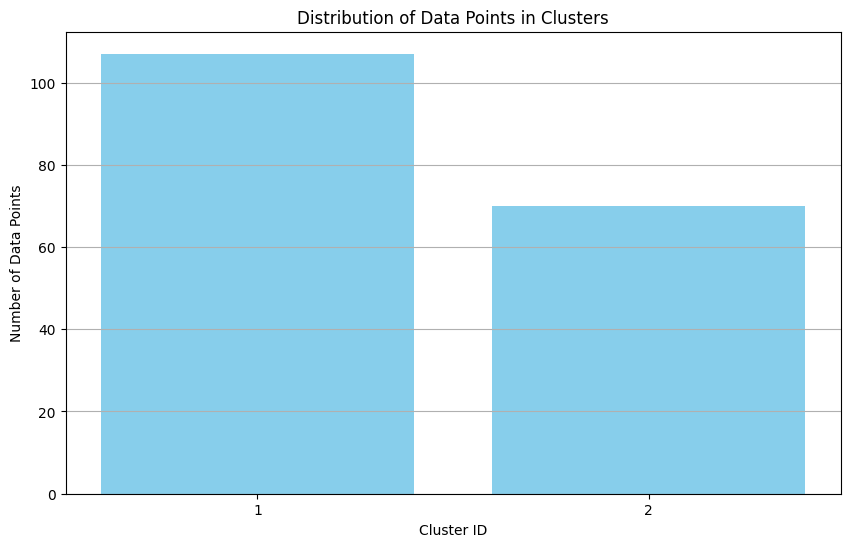

C:\Users\HP\AppData\Local\Temp\ipykernel_30016\2320390952.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', K)


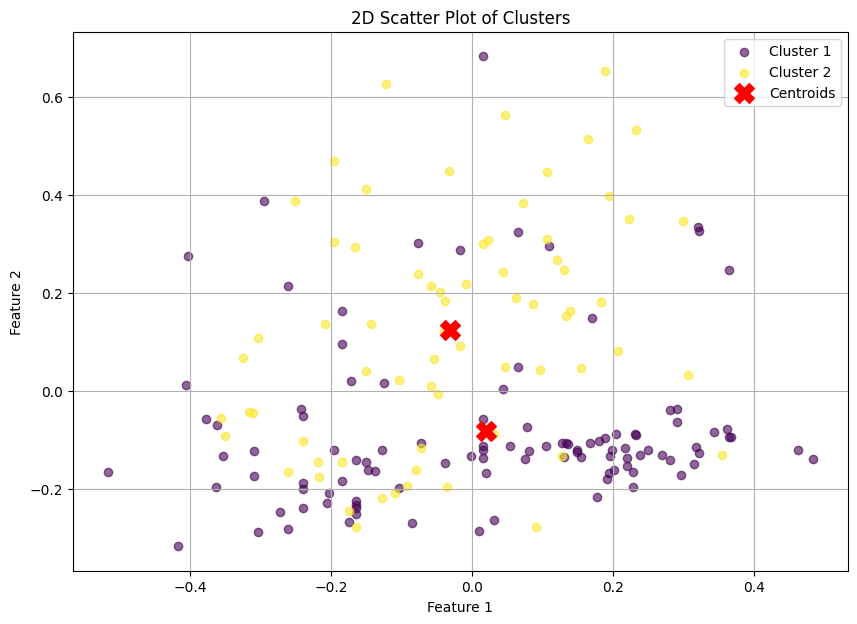

C:\Users\HP\AppData\Local\Temp\ipykernel_30016\2320390952.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', K)


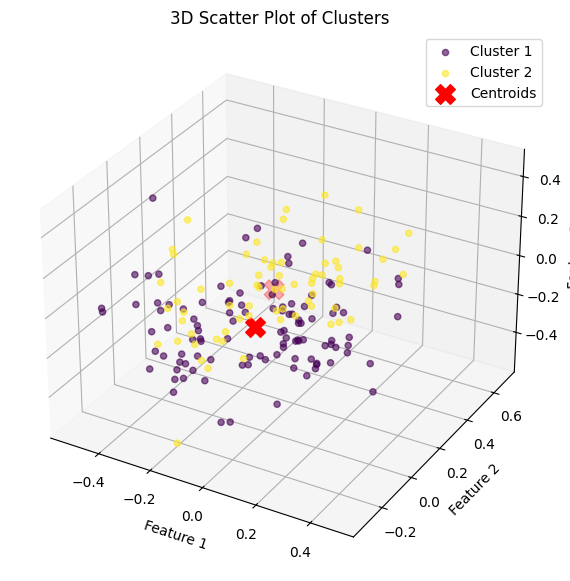

3 = {1.0: 60, 2.0: 64, 3.0: 53}
3 = {1.0: 62, 2.0: 55, 3.0: 60}
3 = {1.0: 51, 2.0: 64, 3.0: 62}
3 = {1.0: 55, 2.0: 60, 3.0: 62}
3 = {1.0: 51, 2.0: 64, 3.0: 62}
3 = {1.0: 62, 2.0: 64, 3.0: 51}
3 = {1.0: 62, 2.0: 60, 3.0: 55}
3 = {1.0: 62, 2.0: 54, 3.0: 61}
3 = {1.0: 62, 2.0: 51, 3.0: 64}
3 = {1.0: 62, 2.0: 64, 3.0: 51}
3 = {1.0: 51, 2.0: 64, 3.0: 62}
3 = {1.0: 60, 2.0: 62, 3.0: 55}
3 = {1.0: 64, 2.0: 51, 3.0: 62}
3 = {1.0: 55, 2.0: 60, 3.0: 62}
3 = {1.0: 62, 2.0: 51, 3.0: 64}
3 = {1.0: 64, 2.0: 51, 3.0: 62}
3 = {1.0: 62, 2.0: 64, 3.0: 51}
3 = {1.0: 61, 2.0: 54, 3.0: 62}
3 = {1.0: 51, 2.0: 64, 3.0: 62}
3 = {1.0: 62, 2.0: 64, 3.0: 51}


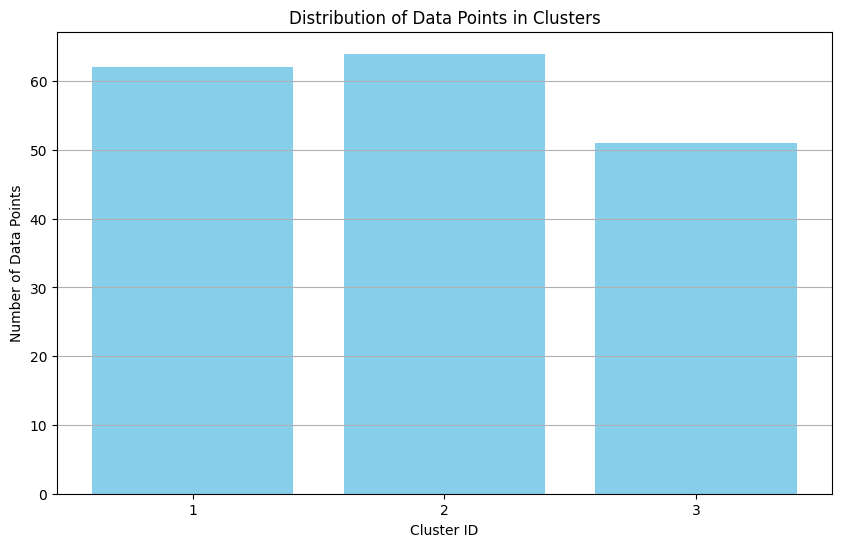

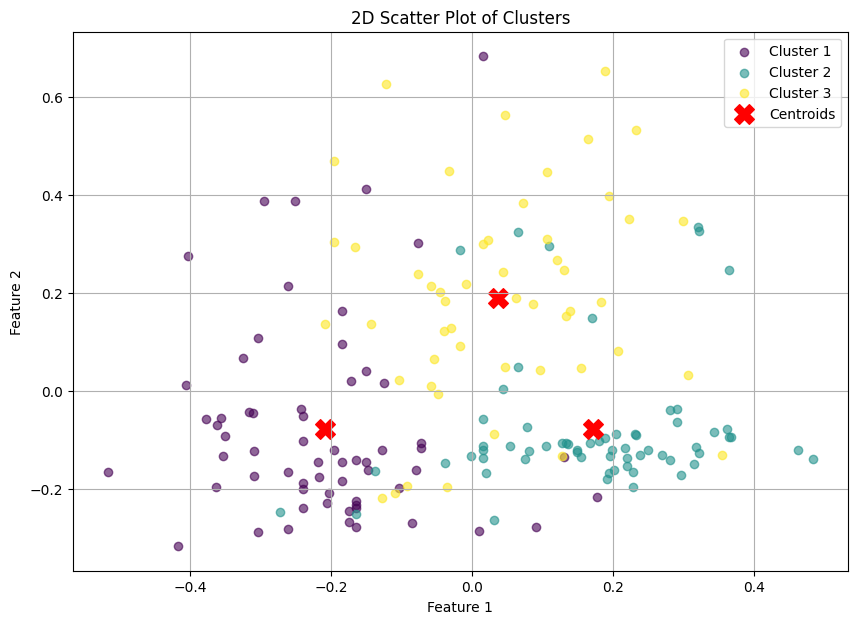

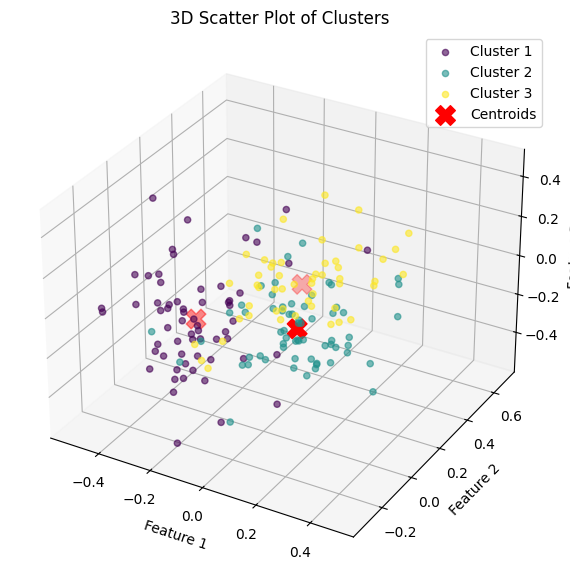

4 = {1.0: 49, 2.0: 21, 3.0: 59, 4.0: 48}
4 = {1.0: 36, 2.0: 28, 3.0: 54, 4.0: 59}
4 = {1.0: 29, 2.0: 44, 3.0: 50, 4.0: 54}
4 = {1.0: 62, 2.0: 13, 3.0: 60, 4.0: 42}
4 = {1.0: 57, 2.0: 45, 3.0: 64, 4.0: 11}
4 = {1.0: 50, 2.0: 44, 3.0: 54, 4.0: 29}
4 = {1.0: 31, 2.0: 60, 3.0: 60, 4.0: 26}
4 = {1.0: 29, 2.0: 23, 3.0: 64, 4.0: 61}
4 = {1.0: 35, 2.0: 57, 3.0: 36, 4.0: 49}
4 = {1.0: 41, 2.0: 64, 3.0: 60, 4.0: 12}
4 = {1.0: 59, 2.0: 25, 3.0: 46, 4.0: 47}
4 = {1.0: 51, 2.0: 12, 3.0: 53, 4.0: 61}
4 = {1.0: 44, 2.0: 29, 3.0: 50, 4.0: 54}
4 = {1.0: 59, 2.0: 54, 3.0: 43, 4.0: 21}
4 = {1.0: 54, 2.0: 44, 3.0: 29, 4.0: 50}
4 = {1.0: 59, 2.0: 35, 3.0: 23, 4.0: 60}
4 = {1.0: 51, 2.0: 37, 3.0: 61, 4.0: 28}
4 = {1.0: 22, 2.0: 59, 3.0: 47, 4.0: 49}
4 = {1.0: 25, 2.0: 44, 3.0: 51, 4.0: 57}
4 = {1.0: 47, 2.0: 25, 3.0: 59, 4.0: 46}


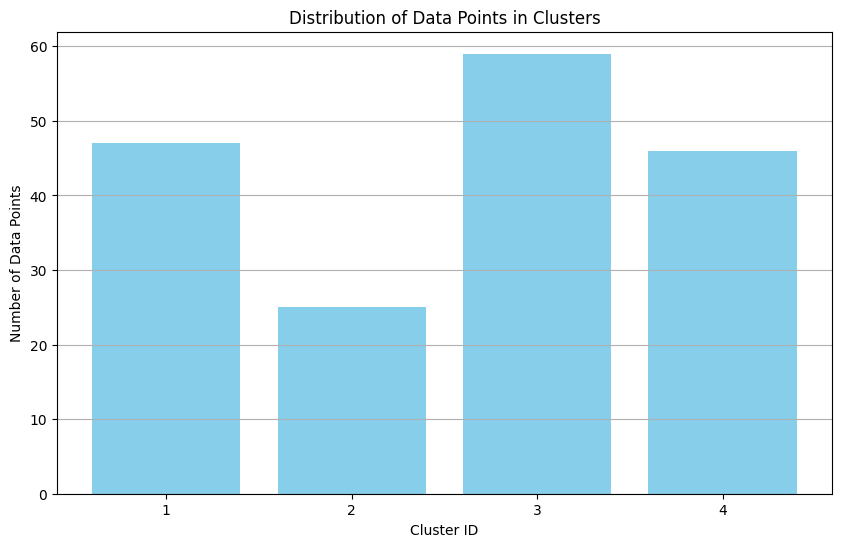

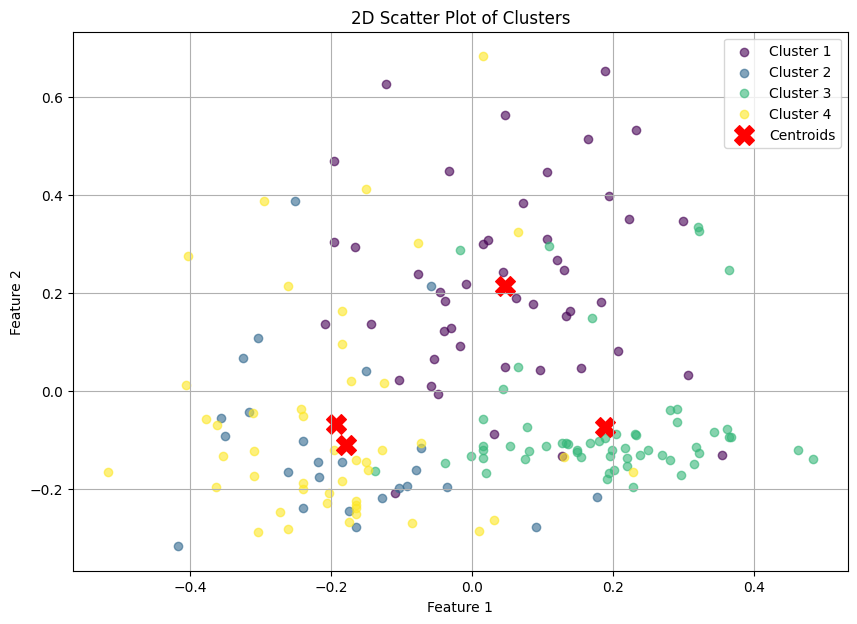

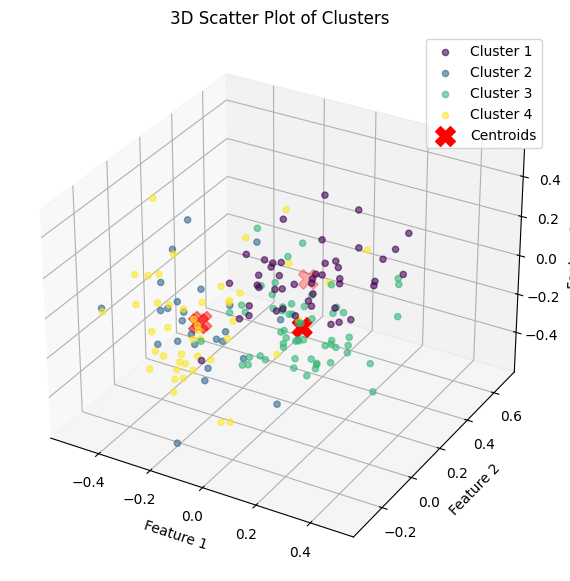

5 = {1.0: 33, 2.0: 49, 3.0: 57, 4.0: 34, 5.0: 4}
5 = {1.0: 1, 2.0: 18, 3.0: 61, 4.0: 51, 5.0: 46}
5 = {1.0: 5, 2.0: 3, 3.0: 61, 4.0: 57, 5.0: 51}
5 = {1.0: 49, 2.0: 19, 3.0: 54, 4.0: 25, 5.0: 30}
5 = {1.0: 38, 2.0: 38, 3.0: 56, 4.0: 27, 5.0: 18}
5 = {1.0: 60, 2.0: 25, 3.0: 40, 4.0: 31, 5.0: 21}
5 = {1.0: 60, 2.0: 25, 3.0: 62, 4.0: 14, 5.0: 16}
5 = {1.0: 30, 2.0: 29, 3.0: 24, 4.0: 44, 5.0: 50}
5 = {1.0: 26, 2.0: 57, 3.0: 26, 4.0: 24, 5.0: 44}
5 = {1.0: 47, 2.0: 50, 3.0: 26, 4.0: 43, 5.0: 11}
5 = {1.0: 29, 2.0: 50, 3.0: 12, 4.0: 42, 5.0: 44}
5 = {1.0: 42, 2.0: 54, 3.0: 50, 4.0: 4, 5.0: 27}
5 = {1.0: 27, 2.0: 50, 3.0: 54, 4.0: 4, 5.0: 42}
5 = {1.0: 52, 2.0: 17, 3.0: 43, 4.0: 15, 5.0: 50}
5 = {1.0: 32, 2.0: 46, 3.0: 51, 4.0: 23, 5.0: 25}
5 = {1.0: 35, 2.0: 28, 3.0: 52, 4.0: 27, 5.0: 35}
5 = {1.0: 48, 2.0: 38, 3.0: 31, 4.0: 58, 5.0: 2}
5 = {1.0: 39, 2.0: 16, 3.0: 56, 4.0: 4, 5.0: 62}
5 = {1.0: 22, 2.0: 54, 3.0: 8, 4.0: 58, 5.0: 35}
5 = {1.0: 48, 2.0: 39, 3.0: 33, 4.0: 34, 5.0: 23}


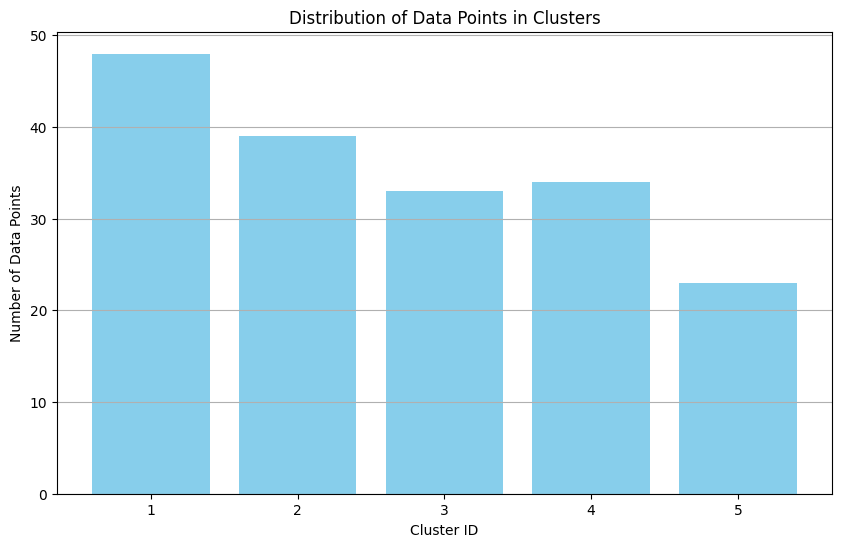

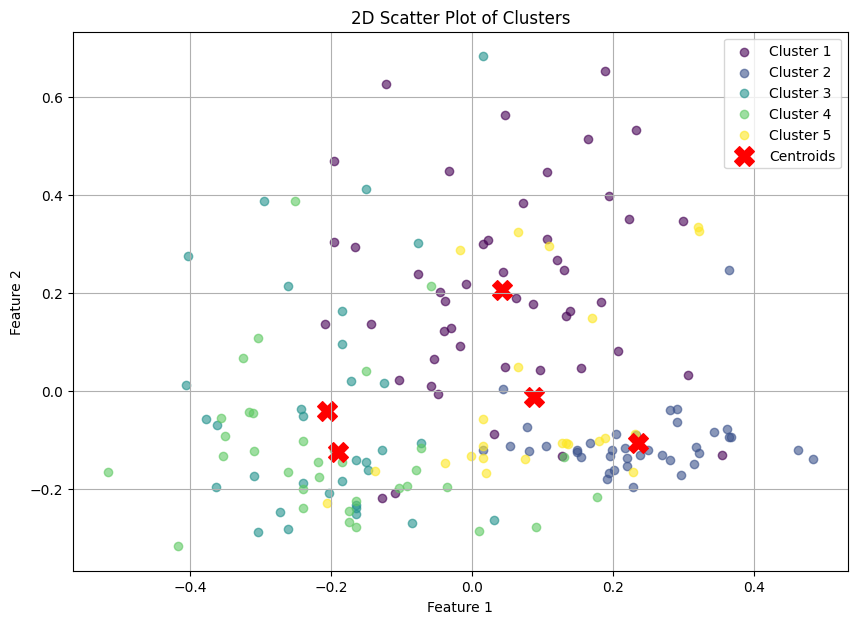

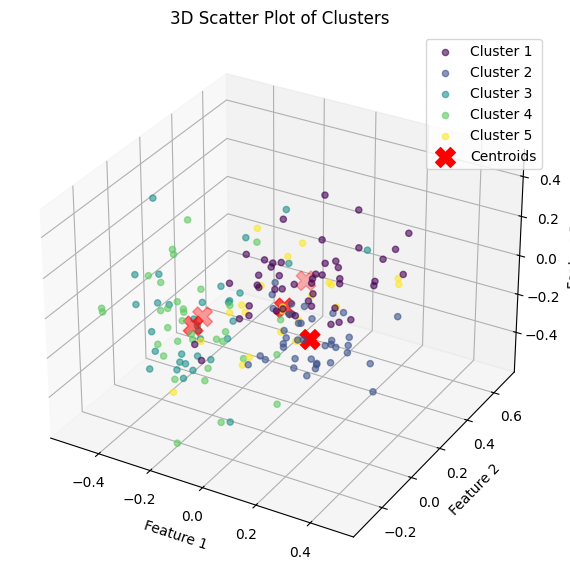

6 = {1.0: 34, 2.0: 33, 3.0: 21, 4.0: 37, 5.0: 15, 6.0: 37}
6 = {1.0: 26, 2.0: 11, 3.0: 54, 4.0: 24, 5.0: 24, 6.0: 38}
6 = {1.0: 23, 2.0: 30, 3.0: 47, 4.0: 16, 5.0: 50, 6.0: 11}
6 = {1.0: 12, 2.0: 42, 3.0: 25, 4.0: 43, 5.0: 37, 6.0: 18}
6 = {1.0: 40, 2.0: 31, 3.0: 58, 4.0: 37, 5.0: 8, 6.0: 3}
6 = {1.0: 38, 2.0: 21, 3.0: 21, 4.0: 39, 5.0: 29, 6.0: 29}
6 = {1.0: 59, 2.0: 3, 3.0: 24, 4.0: 21, 5.0: 24, 6.0: 46}
6 = {1.0: 33, 2.0: 24, 3.0: 19, 4.0: 25, 5.0: 33, 6.0: 43}
6 = {1.0: 38, 2.0: 23, 3.0: 23, 4.0: 6, 5.0: 58, 6.0: 29}
6 = {1.0: 14, 2.0: 18, 3.0: 33, 4.0: 38, 5.0: 20, 6.0: 54}
6 = {1.0: 20, 2.0: 21, 3.0: 35, 4.0: 54, 5.0: 25, 6.0: 22}
6 = {1.0: 24, 2.0: 27, 3.0: 26, 4.0: 35, 5.0: 31, 6.0: 34}
6 = {1.0: 22, 2.0: 27, 3.0: 23, 4.0: 13, 5.0: 50, 6.0: 42}
6 = {1.0: 35, 2.0: 49, 3.0: 35, 4.0: 31, 5.0: 6, 6.0: 21}
6 = {1.0: 16, 2.0: 21, 3.0: 35, 4.0: 47, 5.0: 26, 6.0: 32}
6 = {1.0: 29, 2.0: 30, 3.0: 24, 4.0: 50, 5.0: 17, 6.0: 27}
6 = {1.0: 12, 2.0: 23, 3.0: 32, 4.0: 30, 5.0: 29, 6.0: 51}
6 

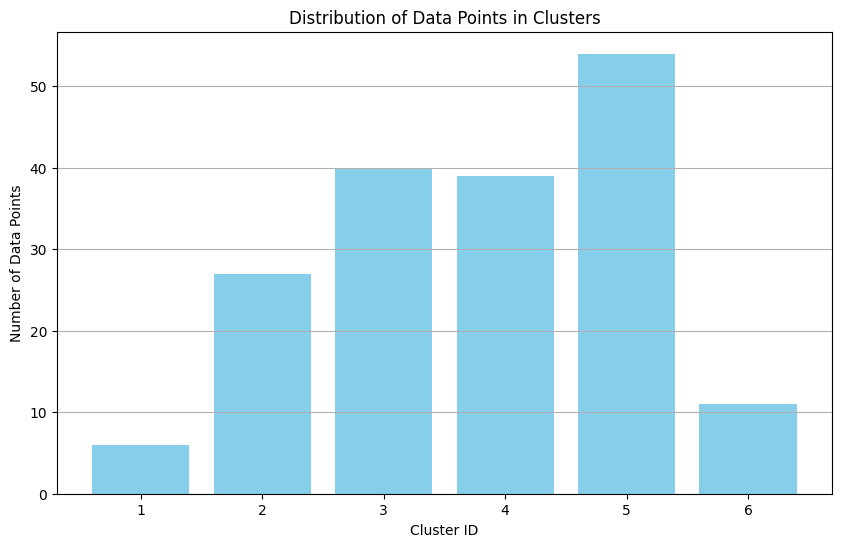

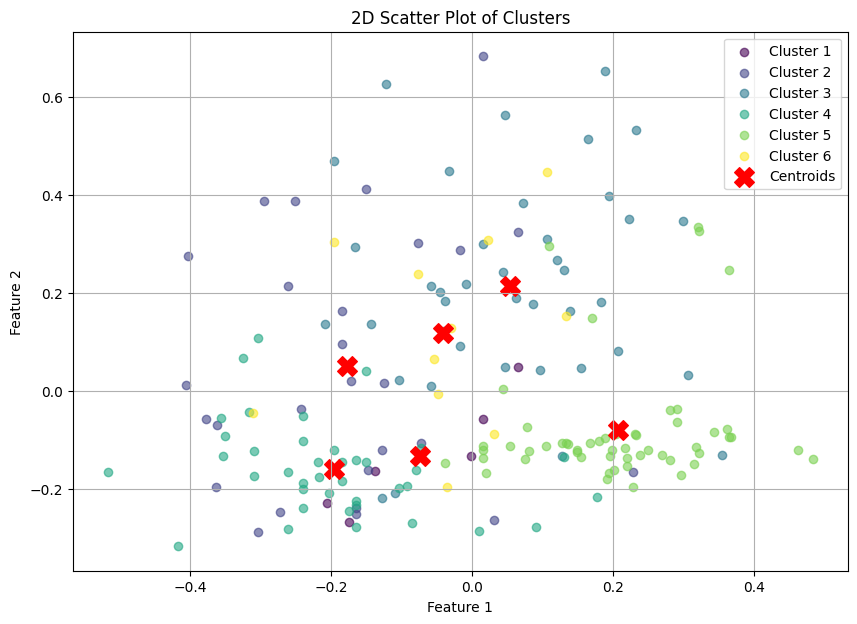

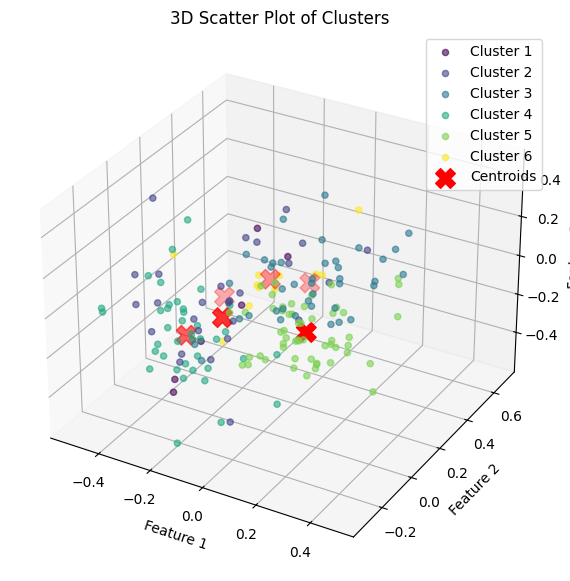

7 = {1.0: 20, 2.0: 4, 3.0: 10, 4.0: 19, 5.0: 27, 6.0: 58, 7.0: 39}
7 = {1.0: 40, 2.0: 58, 3.0: 24, 4.0: 15, 5.0: 16, 6.0: 13, 7.0: 11}
7 = {1.0: 34, 2.0: 27, 3.0: 14, 4.0: 21, 5.0: 40, 6.0: 23, 7.0: 18}
7 = {1.0: 26, 2.0: 26, 3.0: 36, 4.0: 3, 5.0: 24, 6.0: 38, 7.0: 24}
7 = {1.0: 24, 2.0: 49, 3.0: 11, 4.0: 28, 5.0: 42, 6.0: 9, 7.0: 14}
7 = {1.0: 40, 2.0: 4, 3.0: 4, 4.0: 11, 5.0: 24, 6.0: 40, 7.0: 54}
7 = {1.0: 13, 2.0: 3, 3.0: 57, 4.0: 31, 5.0: 39, 6.0: 29, 7.0: 5}
7 = {1.0: 26, 2.0: 15, 3.0: 19, 4.0: 33, 5.0: 47, 6.0: 33, 7.0: 4}
7 = {1.0: 54, 2.0: 15, 3.0: 22, 4.0: 14, 5.0: 27, 6.0: 23, 7.0: 22}
7 = {1.0: 20, 2.0: 8, 3.0: 54, 4.0: 16, 5.0: 26, 6.0: 21, 7.0: 32}
7 = {1.0: 1, 2.0: 29, 3.0: 4, 4.0: 24, 5.0: 31, 6.0: 48, 7.0: 40}
7 = {1.0: 19, 2.0: 29, 3.0: 31, 4.0: 33, 5.0: 24, 6.0: 11, 7.0: 30}
7 = {1.0: 13, 2.0: 19, 3.0: 54, 4.0: 2, 5.0: 19, 6.0: 31, 7.0: 39}
7 = {1.0: 26, 2.0: 27, 3.0: 50, 4.0: 25, 5.0: 24, 6.0: 2, 7.0: 23}
7 = {1.0: 18, 2.0: 19, 3.0: 18, 4.0: 33, 5.0: 9, 6.0: 37, 7.0

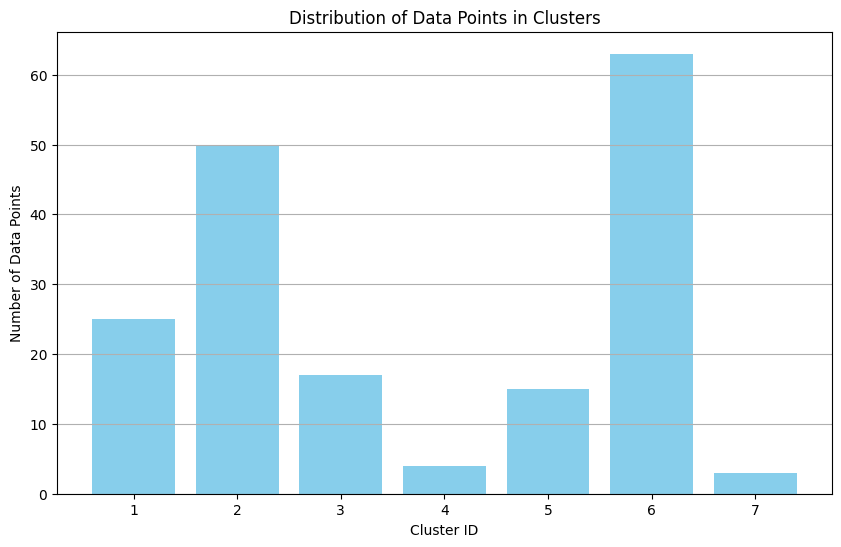

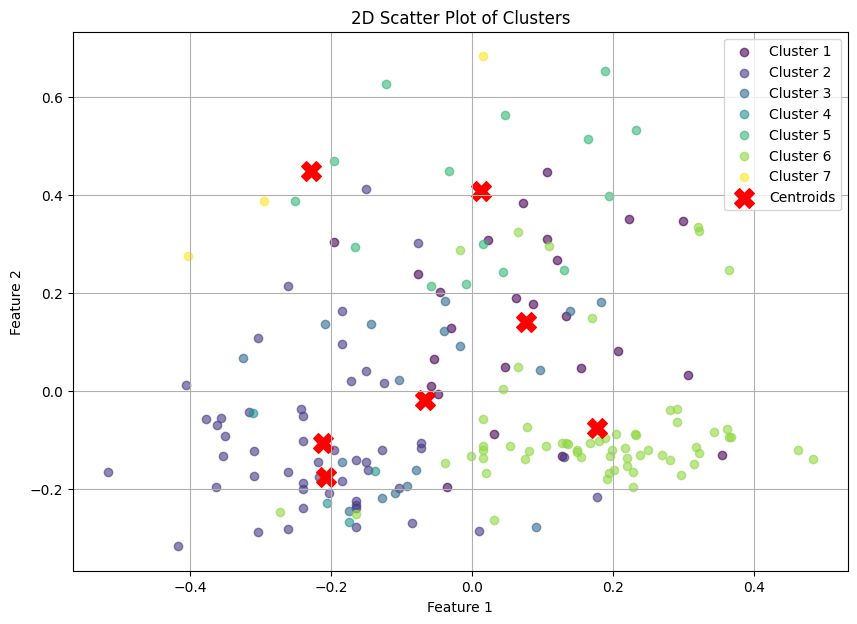

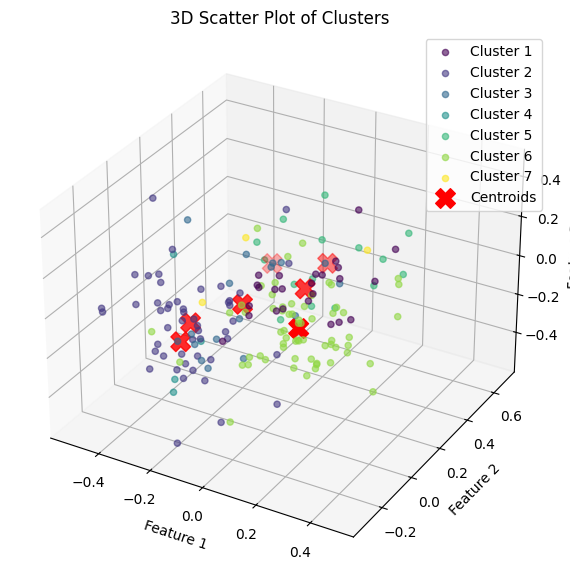

8 = {1.0: 41, 2.0: 37, 3.0: 12, 4.0: 19, 5.0: 16, 6.0: 11, 7.0: 23, 8.0: 18}
8 = {1.0: 38, 2.0: 39, 3.0: 20, 4.0: 12, 5.0: 19, 6.0: 17, 7.0: 11, 8.0: 21}
8 = {1.0: 29, 2.0: 18, 3.0: 16, 4.0: 10, 5.0: 14, 6.0: 30, 7.0: 41, 8.0: 19}
8 = {1.0: 10, 2.0: 18, 3.0: 19, 4.0: 15, 5.0: 26, 6.0: 55, 7.0: 18, 8.0: 16}
8 = {1.0: 10, 2.0: 18, 3.0: 21, 4.0: 16, 5.0: 54, 6.0: 14, 7.0: 39, 8.0: 5}
8 = {1.0: 14, 2.0: 11, 3.0: 21, 4.0: 16, 5.0: 28, 6.0: 56, 7.0: 2, 8.0: 29}
8 = {1.0: 11, 2.0: 14, 3.0: 42, 4.0: 5, 5.0: 26, 6.0: 18, 7.0: 26, 8.0: 35}
8 = {1.0: 16, 2.0: 5, 3.0: 54, 4.0: 13, 5.0: 38, 6.0: 12, 7.0: 24, 8.0: 15}
8 = {1.0: 1, 2.0: 12, 3.0: 10, 4.0: 54, 5.0: 36, 6.0: 15, 7.0: 22, 8.0: 27}
8 = {1.0: 12, 2.0: 12, 3.0: 29, 4.0: 54, 5.0: 27, 6.0: 26, 7.0: 14, 8.0: 3}
8 = {1.0: 27, 2.0: 22, 3.0: 18, 4.0: 28, 5.0: 23, 6.0: 11, 7.0: 45, 8.0: 3}
8 = {1.0: 22, 2.0: 19, 3.0: 25, 4.0: 26, 5.0: 27, 6.0: 4, 7.0: 1, 8.0: 53}
8 = {1.0: 22, 2.0: 29, 3.0: 3, 4.0: 38, 5.0: 50, 6.0: 14, 7.0: 1, 8.0: 20}
8 = {1.0: 

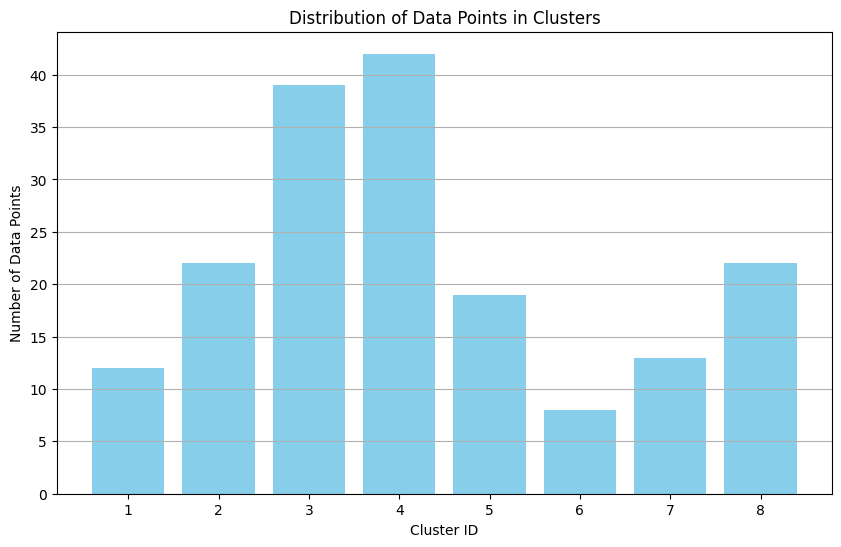

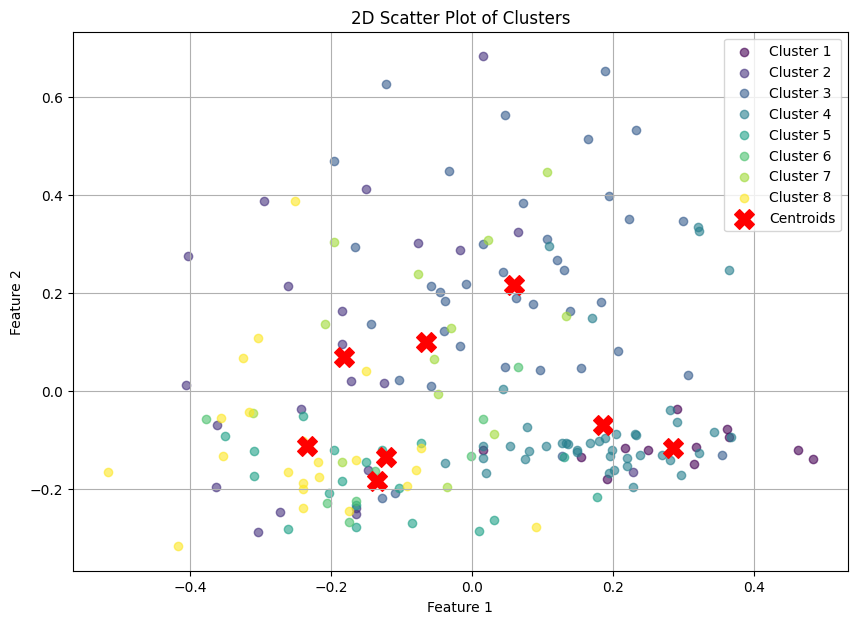

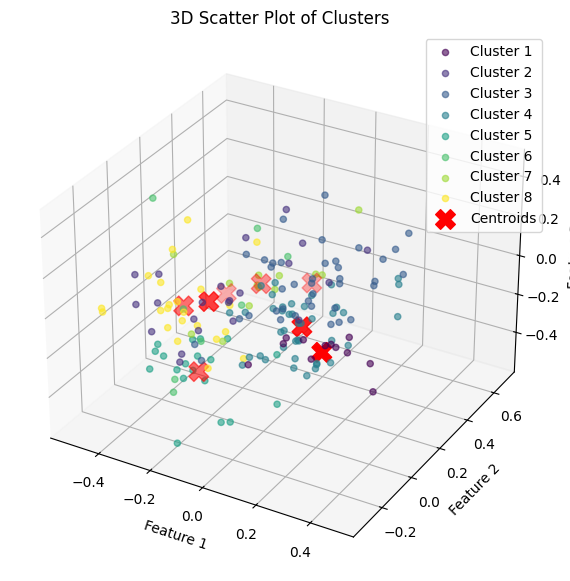

9 = {1.0: 12, 2.0: 2, 3.0: 27, 4.0: 19, 5.0: 24, 6.0: 30, 7.0: 20, 8.0: 18, 9.0: 25}
9 = {1.0: 29, 2.0: 22, 3.0: 5, 4.0: 26, 5.0: 21, 6.0: 25, 7.0: 12, 8.0: 23, 9.0: 14}
9 = {1.0: 20, 2.0: 26, 3.0: 22, 4.0: 11, 5.0: 17, 6.0: 12, 7.0: 35, 8.0: 21, 9.0: 13}
9 = {1.0: 23, 2.0: 4, 3.0: 29, 4.0: 17, 5.0: 3, 6.0: 23, 7.0: 19, 8.0: 25, 9.0: 34}
9 = {1.0: 10, 2.0: 23, 3.0: 7, 4.0: 25, 5.0: 17, 6.0: 35, 7.0: 37, 8.0: 4, 9.0: 19}
9 = {1.0: 8, 2.0: 21, 3.0: 10, 4.0: 27, 5.0: 19, 6.0: 26, 7.0: 32, 8.0: 13, 9.0: 21}
9 = {1.0: 6, 2.0: 22, 3.0: 35, 4.0: 24, 5.0: 19, 6.0: 9, 7.0: 21, 8.0: 31, 9.0: 10}
9 = {1.0: 15, 2.0: 20, 3.0: 4, 4.0: 17, 5.0: 20, 6.0: 37, 7.0: 10, 8.0: 18, 9.0: 36}
9 = {1.0: 26, 2.0: 22, 3.0: 22, 4.0: 11, 5.0: 17, 6.0: 18, 7.0: 14, 8.0: 25, 9.0: 22}
9 = {1.0: 20, 2.0: 10, 3.0: 20, 4.0: 36, 5.0: 8, 6.0: 50, 7.0: 8, 8.0: 12, 9.0: 13}
9 = {1.0: 17, 2.0: 19, 3.0: 19, 4.0: 23, 5.0: 16, 6.0: 19, 7.0: 30, 8.0: 15, 9.0: 19}
9 = {1.0: 18, 2.0: 19, 3.0: 28, 4.0: 15, 5.0: 20, 6.0: 48, 7.0: 13

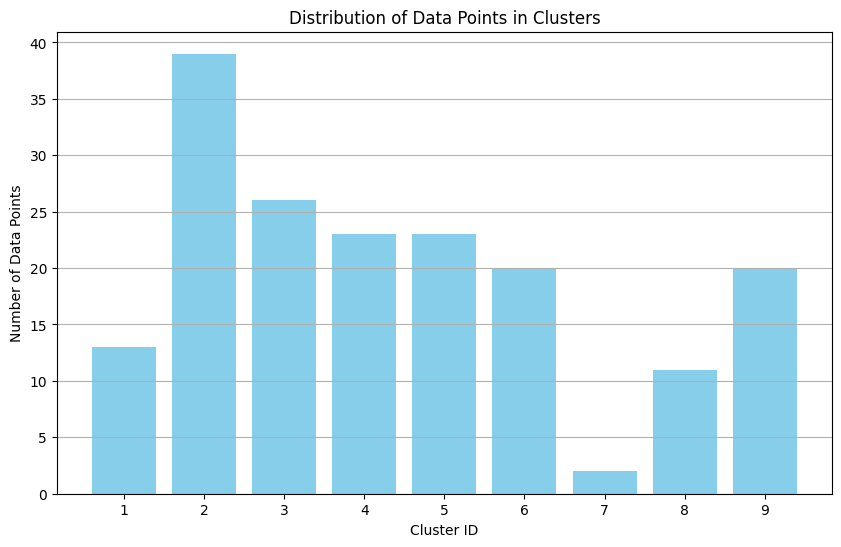

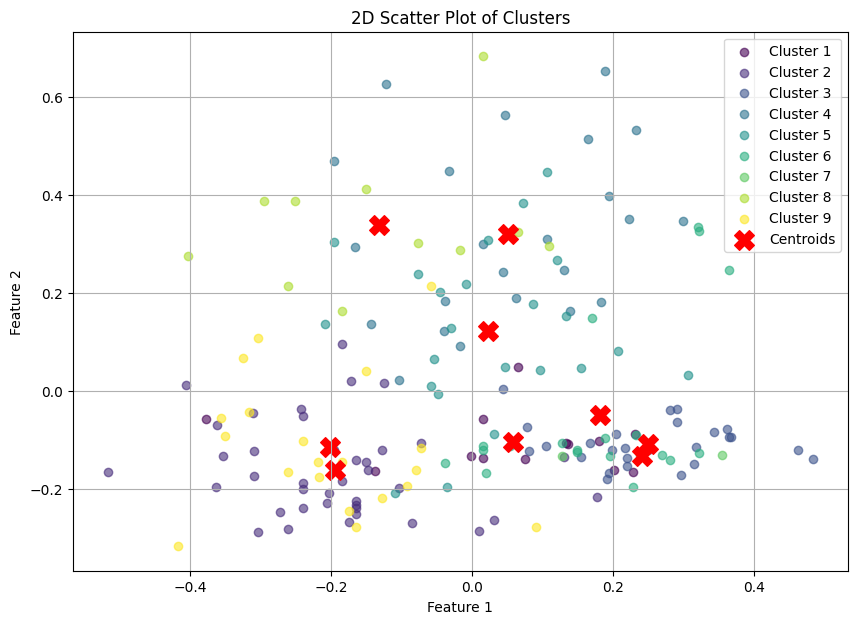

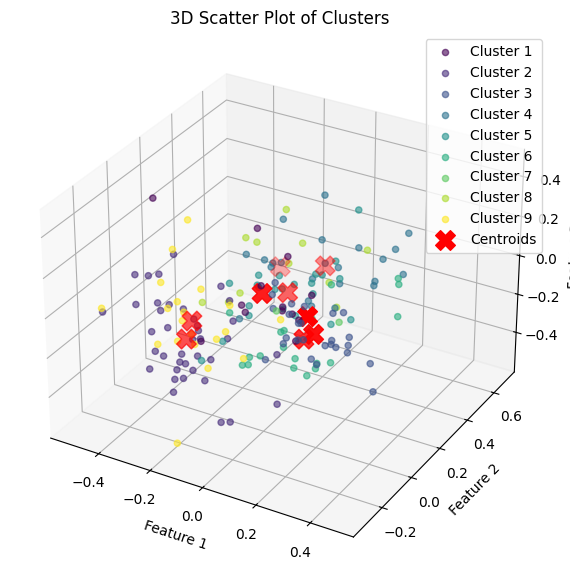

10 = {1.0: 9, 2.0: 10, 3.0: 29, 4.0: 27, 5.0: 31, 6.0: 15, 7.0: 22, 8.0: 18, 9.0: 10, 10.0: 6}
10 = {1.0: 6, 2.0: 3, 3.0: 23, 4.0: 10, 5.0: 5, 6.0: 29, 7.0: 56, 8.0: 3, 9.0: 20, 10.0: 22}
10 = {1.0: 25, 2.0: 10, 3.0: 9, 4.0: 13, 5.0: 12, 6.0: 4, 7.0: 27, 8.0: 15, 9.0: 32, 10.0: 30}
10 = {1.0: 18, 2.0: 27, 3.0: 16, 4.0: 6, 5.0: 8, 6.0: 37, 7.0: 13, 8.0: 20, 9.0: 18, 10.0: 14}
10 = {1.0: 19, 2.0: 17, 3.0: 16, 4.0: 5, 5.0: 18, 6.0: 27, 7.0: 6, 8.0: 15, 9.0: 35, 10.0: 19}
10 = {1.0: 14, 2.0: 4, 3.0: 32, 4.0: 25, 5.0: 6, 6.0: 8, 7.0: 21, 8.0: 30, 9.0: 34, 10.0: 3}
10 = {1.0: 5, 2.0: 10, 3.0: 20, 4.0: 24, 5.0: 17, 6.0: 16, 7.0: 14, 8.0: 47, 9.0: 14, 10.0: 10}
10 = {1.0: 10, 2.0: 21, 3.0: 15, 4.0: 35, 5.0: 9, 6.0: 14, 7.0: 30, 8.0: 8, 9.0: 14, 10.0: 21}
10 = {1.0: 42, 2.0: 26, 3.0: 22, 4.0: 10, 5.0: 11, 6.0: 36, 7.0: 15, 8.0: 10, 9.0: 1, 10.0: 4}
10 = {1.0: 14, 2.0: 8, 3.0: 19, 4.0: 16, 5.0: 15, 6.0: 7, 7.0: 23, 8.0: 18, 9.0: 47, 10.0: 10}
10 = {1.0: 34, 2.0: 19, 3.0: 18, 4.0: 2, 5.0: 18, 6.0

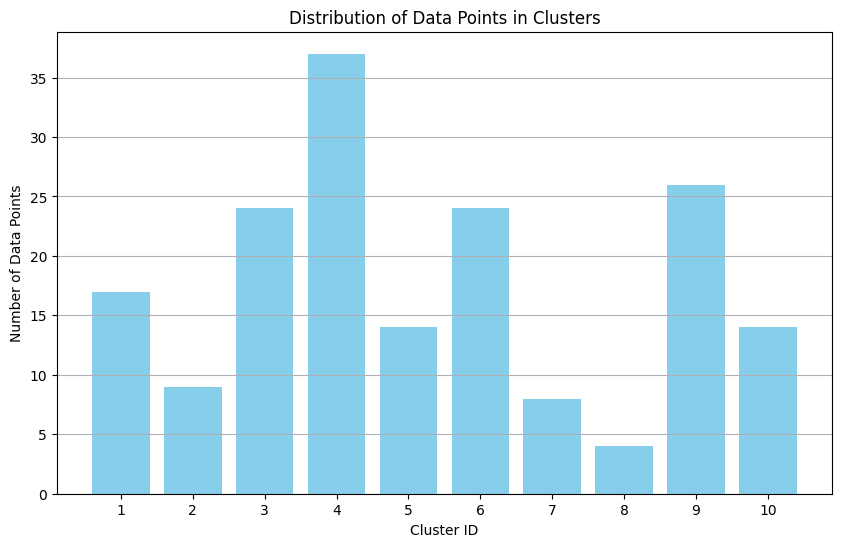

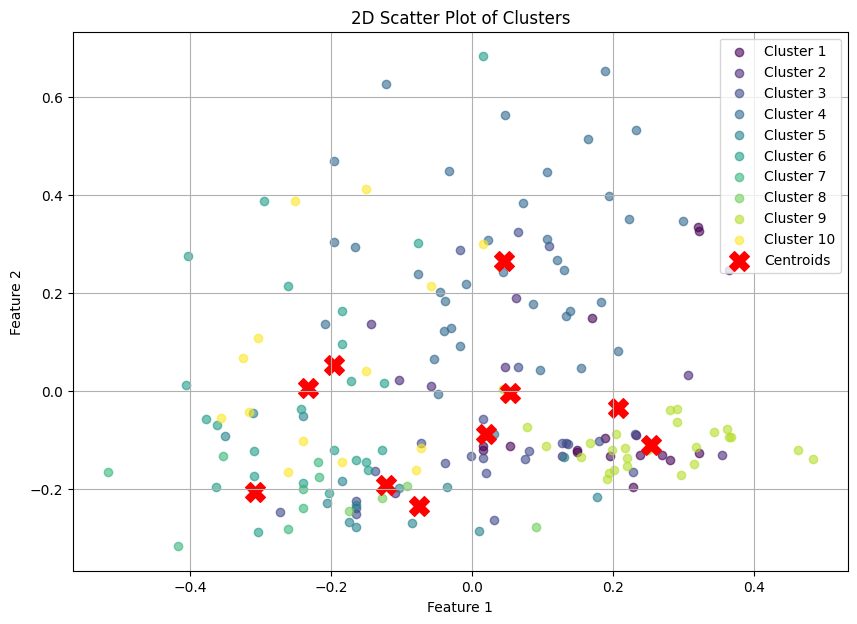

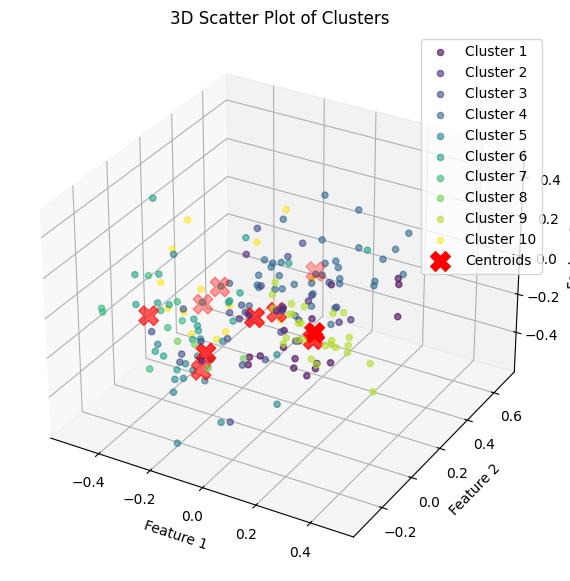

In [47]:
run_test()